# Create yearly welder usage profile based on measured usage

### Definitions
**Usage Profile**: A usage profile is a unitless series of how often the welder is used on an hourly basis throughout a year. Being unitless allows us to apply costs, power or other factors to generate load, throughput or cost profiles. 

**day_hour**: Monday at 2pm is a single `day_hour` for example. Monday at 3pm is a different `day_hour`. There are 24 hours x 7 days = 168 `day_hour`s.

### General Steps
1. Import measured usage data from a welder. This data is in 2 minute increments and has a usage value associated with it. 
2. Filter out any noise, where any usage value below 100 would be considered "off". Count anything greater than that as "on" (assign a value of 1) for that 2 minute interval.
3. Resample 2 minute data to 1 hour data, summing new welder values. 
4. Group data by `day_hour`s and export for web app
5. Generate a yearly profile by randomly sampling measured `day_hour`s and applying them to the rest of the year.
6. Compare stats of yearly usage profile to measured usage profile to make sure we made reasonable assumptions

### Notes
* Screenshots are included in this notebook because the interactive pivot tables don't print well and need explanation. If any other dataset us used besides the Tanzania welder data these screenshots will no longer be relevant. Duplicate this workbook, delete the screenshots,  uncomment the `pivot_ui` code and execute it. 

## Setup & Library Imports

In [66]:
# Reset all variables so that we can 'run all cells' and not get unused variables hanging around
%reset -f

# Most of this comes with anaconda distribution. I thinkt the only one 
# you have to install is:
# conda install pivottablejs
import pandas as pd
import numpy as np
from pivottablejs import pivot_ui
from collections import defaultdict
from functools import partial
import random
import json
import pytz

# Should have pandas 0.23 or greater. If not and you're using Anaconda for packages, 
# do this in the terminal: `conda update pandas`
pd.__version__    

'0.23.4'

## Import Welder Data

In [67]:
excel_file_path = 'inputs/Welder_LP_Tanzania_20180910-20180920.xlsx'
sheet_name='Welder_Tanzania LP'
output_generator_data_name='output/welder_generator_data.json'
output_profile_name = 'output/welder_usage_profile.csv'

# Import Excel file, specify the sheet & import it into a Pandas Dataframe.
# Rename columns so they are shorter and easier to work with.
# df is short for Pandas DataFrame - it makes it clearer what this datastructure is
df_measured_2min = pd.read_excel(excel_file_path, sheet_name=sheet_name)
df_measured_2min = df_measured_2min.rename(columns={'Timestamp (GMT)': 'time_gmt', 'Value': 'welder_value'})
df_measured_2min.head()

,time_gmt,welder_value
0,2018-09-08 01:42:30,0
1,2018-09-08 01:44:30,0
2,2018-09-08 01:46:30,0
3,2018-09-08 01:48:30,0
4,2018-09-08 01:50:30,0


In [68]:
df_measured_2min.shape  # Look at number of (rows, columns)

(9319, 2)

## Convert Timezone

In [69]:
# To see all timezones available (but select only the first 55 to see Africa): 
# pytz.all_timezones[0:55]  

In [70]:
# There was no Tanzania listed. Nairobi is +3 which is the same as Tanzania
# There should not be a problem with daylight savings time - from my research neither observe it
tanzania_tz = pytz.timezone('Africa/Nairobi')

In [71]:
# Convert date string to proper datetime so we can work with timezones
df_measured_2min['time_gmt'] = pd.to_datetime(df_measured_2min['time_gmt'])

In [72]:
# Add local time
df_measured_2min['time_local'] = df_measured_2min['time_gmt'].dt.tz_localize('utc').dt.tz_convert(tanzania_tz)
df_measured_2min.head()

,time_gmt,welder_value,time_local
0,2018-09-08 01:42:30,0,2018-09-08 04:42:30+03:00
1,2018-09-08 01:44:30,0,2018-09-08 04:44:30+03:00
2,2018-09-08 01:46:30,0,2018-09-08 04:46:30+03:00
3,2018-09-08 01:48:30,0,2018-09-08 04:48:30+03:00
4,2018-09-08 01:50:30,0,2018-09-08 04:50:30+03:00


## Filter out on/off welder noise

In [73]:
# If a `welder_value` is less than 100, it's probably not actual usage.
# Set anything less than that threshold to zero.
noise_threshold = 100
df_measured_2min['welder_on_count'] = np.where(df_measured_2min['welder_value'] > noise_threshold, 1, 0 )

# Show a slice of records that indicate successful filtering
df_measured_2min[60:70]

,time_gmt,welder_value,time_local,welder_on_count
60,2018-09-08 03:42:30,15,2018-09-08 06:42:30+03:00,0
61,2018-09-08 03:44:30,3,2018-09-08 06:44:30+03:00,0
62,2018-09-08 03:46:30,2,2018-09-08 06:46:30+03:00,0
63,2018-09-08 03:48:30,18,2018-09-08 06:48:30+03:00,0
64,2018-09-08 03:50:30,22,2018-09-08 06:50:30+03:00,0
65,2018-09-08 03:52:30,0,2018-09-08 06:52:30+03:00,0
66,2018-09-08 03:54:30,417,2018-09-08 06:54:30+03:00,1
67,2018-09-08 03:56:30,0,2018-09-08 06:56:30+03:00,0
68,2018-09-08 03:58:30,0,2018-09-08 06:58:30+03:00,0
69,2018-09-08 04:00:14,0,2018-09-08 07:00:14+03:00,0


## Utilization per usage interval (not used)

In [74]:
# Assume for any 2 minute logged interval that the actual utilization rate 
# is 25%. In other words, in 2 minutes the welder is actually used for 30s.

# I think this is better done in the app so we will skip it here.
# If we did do it here, it would look like this:

# utilization_while_logged = 0.25
# df_measured_2min['welder_utilization'] = df_measured_2min['welder_on_count'] * utilization_while_logged
# df_measured_2min[60:70]

## Resample 2-min intervals to hourly intevals

Here is a good example of how to resample time-series data: https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea

In [75]:
# The dataframe must have an index type of datetime (instead of a default 
# integer) in order to resample to hourly intervals. 
# Set the index to our local time
df_measured_2min_index = df_measured_2min.set_index('time_local')
df_measured_2min_index[60:67]

,time_gmt,welder_value,welder_on_count
time_local,,,
2018-09-08 06:42:30+03:00,2018-09-08 03:42:30,15,0
2018-09-08 06:44:30+03:00,2018-09-08 03:44:30,3,0
2018-09-08 06:46:30+03:00,2018-09-08 03:46:30,2,0
2018-09-08 06:48:30+03:00,2018-09-08 03:48:30,18,0
2018-09-08 06:50:30+03:00,2018-09-08 03:50:30,22,0
2018-09-08 06:52:30+03:00,2018-09-08 03:52:30,0,0
2018-09-08 06:54:30+03:00,2018-09-08 03:54:30,417,1


In [76]:
# Now we can query the dataframe based on different time intevals. Some examples:
# df_2min_index[df_2min_index.index.hour == 2]  # Get all rows for 2am
# df_2min_index['2018-09-08']                   # Get all rows for that date
# df_2min_index['2018-09-08':'2018-09-10']      # Get all rows between these dates

# Get every interval within an hour. We will reference this same hour
# later after resampling to show that the sum within that hour add up
df_measured_2min_index['2018-09-08 09:00':'2018-09-08 09:58']

,time_gmt,welder_value,welder_on_count
time_local,,,
2018-09-08 09:00:14+03:00,2018-09-08 06:00:14,0,0
2018-09-08 09:02:14+03:00,2018-09-08 06:02:14,0,0
2018-09-08 09:04:14+03:00,2018-09-08 06:04:14,0,0
2018-09-08 09:06:14+03:00,2018-09-08 06:06:14,0,0
2018-09-08 09:08:14+03:00,2018-09-08 06:08:14,0,0
2018-09-08 09:10:14+03:00,2018-09-08 06:10:14,0,0
2018-09-08 09:12:14+03:00,2018-09-08 06:12:14,1755,1
2018-09-08 09:14:14+03:00,2018-09-08 06:14:14,3321,1
2018-09-08 09:16:14+03:00,2018-09-08 06:16:14,3016,1


In [77]:
# Resample while summing every 2-min interval within an hour ('H')
# Go ahead and drop the original welder_value since we have counts now
# GMT time will automatically be dropped since you can't sum it
df_measured = df_measured_2min_index.resample('H').sum().drop(columns=['welder_value'])

# The original data had 9319 rows of 2min data. 
# There are 30 two-minute intervals in an hour.
# The new row count should be 9319 / 30 = 311 after resampling to hours
# 311 hours is ~13 days of measured data.
df_measured.shape  # (rows, columns) where column count doesn't include the index

(311, 1)

In [78]:
# Check results:
# You can check that the welder_is_on count for the hourly intervals below 
# is the sum of the welder_is_on counts above (2min intervals).
# Double check this with any new datasets, but it should hold
df_measured['2018-09-08 09:00':'2018-09-08 09:58']

,welder_on_count
time_local,
2018-09-08 09:00:00+03:00,8


## Add hour, day of week, day_hour columns 
These columns will be used later for generating yearly usage profile and aggregate stats.

In [79]:
# Helper functions for making and matching day_hour columns

def shorten_day_name(day_string):
    """Shorten a day name to the first 4 letters (1Saturday => 1sat)
    This requires a string passed in.
    """
    return day_string[0:4].lower()

def composite_val(day_name, hour):
    """Generate a composite string value that can be used for dictionary 
    keys or other uses.
    For example, 1Saturday at 10am => 1sat_10
    """
    padded_hour = str(hour).zfill(2)
    return "{}_{}".format(shorten_day_name(day_name), padded_hour)

In [80]:
# Add the name of the day of the week to the dataframe (Saturday).
# Prepend that name with a number of the day of the week.
# Monday is 0, Tuesday is 1 and so on. This will allows tools to 
# order the days so they are in order: 0Monday, 1Tuesday, otherwise 
# they will be ordered alphabetical.
df_measured["day"] = df_measured.index.dayofweek.map(str) + df_measured.index.day_name()
df_measured["day"] = df_measured["day"].apply(shorten_day_name)

# Add hour of day (as a number)
df_measured['hour_of_day'] = df_measured.index.hour 

# Add day_hour. For example: 4fri_10
# Possible source of confusion: 
# 4fri is just friday. 4fri_10 is Friday at 10am. 
df_measured["day_hour"] = df_measured.apply(lambda row: composite_val(row['day'], row['hour_of_day']), axis=1)

df_measured.sample(15)

,welder_on_count,day,hour_of_day,day_hour
time_local,,,,
2018-09-12 18:00:00+03:00,0,2wed,18,2wed_18
2018-09-20 06:00:00+03:00,0,3thu,6,3thu_06
2018-09-17 00:00:00+03:00,0,0mon,0,0mon_00
2018-09-20 12:00:00+03:00,0,3thu,12,3thu_12
2018-09-08 11:00:00+03:00,26,5sat,11,5sat_11
2018-09-18 09:00:00+03:00,7,1tue,9,1tue_09
2018-09-16 07:00:00+03:00,0,6sun,7,6sun_07
2018-09-11 02:00:00+03:00,0,1tue,2,1tue_02
2018-09-17 23:00:00+03:00,0,0mon,23,0mon_23


## Approach to usage profile verification
It's important to characterize the measured usage so that when we create an artificial usage profile, we can check to see if some of the important metrics are comparable. Our goal is to generate a yearly profile that has natural variation but roughly matches measured load profiles.   

We have 13 days of measured data, which means we have 2 measured values for most `day_hour`s. There is only 1 measured `day_hour` value for a friday (~15% of data points). It's difficult to get reliable stats, such as averages and sums with so few data points. However we can still generate a reasonable usage profile from it. The approach laid out below will get better and better with more measured data.

**[Amanda: below is a hypothesis - open to suggestions]**

Stats that are important to be comparable between measured and generated usage profiles:

1. **Average usage per hour of the day**. For example, the average of all 10am time slots should be comparable between measured and generated data.
2. **Average usage per day**. For example, the average usage for every Monday should be comparable between measured and generated data.

![Screenshot](screenshots/welder_measured_usage_hourly_avg.png)
![Screenshot](screenshots/welder_measured_usage_daily_avg.png)

#### Notes
* The two averages (day of week and hour) could be considered "orthogonal" to each other. They are independent variables and can be visualized on two axis. The `day_hour`s are points in the space defined by those two axes (see screenshot below). 
* The ideal metric would be to have the average for every `day_hour` be comparable. But this isn't feasible with only 2 data points per `day_hour`.
* There are [dangers](https://twitter.com/fperez_org/status/859875971016531968) of using averages to check if two datasets are comparable. However, the more dimensions we compare averages across the less likely we will have problems. Also, by sampling real data, we narrow the possible values that can lead to misrepresentation by averages.
* Alternate approaches:
    * Create a probability density distribution based on measured data and sample from that. But with only 2 datapoints, we would have to make data up to create that distribution. The downside from sampling from real data is that there won't be as much variation in the load as it would from sampling from a probability distribution. The upside is that we aren't making up data and skewing results based on guesses. If the data is skewed now, it's because it reflects data we have, not our guesses. Open to suggestions.
    * Sample across multiple hours or days: This has the advantage of sampling real data instead of an artificial distribution. The disadvantage is that the orthogonality of hour and day of week is partially lost. 

![Screenshot](screenshots/orthogonality_day_hour.png)

In [81]:
# This is an interactive, drag-and-drop pivot table. Uncomment to play with it. 
# Leaving screenshot for static viewing

# pivot_ui(df_measured, 
#          rows=['day_hour'],
#          cols=['welder_on_count'],
#          rendererName="Table",
#          aggregatorName="Average",
#          vals=["welder_on_count"])

##### Screenshot: average welder_on_count per day_hour
![Screenshot](screenshots/welder_measured_data_day_hour_avg.png)

## Approach to generating yearly usage profile

1. Measured usage data: Generate a data file that lists the measured values for all 168 `day_hour`s. It would look like this:
```
measured_usage = {
    0mon_00: [0, 0]     # Monday at midnight
    0mon_01: [0, 0]     # Monday at 1am
    ...
    1tue_09: [7, 0]     # Tuesday @ 9am
    ...
    5sat_10: [0, 1]     # Saturday @ 10am
    ...
}
```
This file can be imported into the web app so that we can create as many yearly profiles as needed dynamically. 

2. Create a year's worth of `day_hour`s with empty data
3. For every `day_hour` in that year, take a random sample from the `day_hour` data in `measured_usage`. In the example above, 50% of the time on Tuesdays at 9am you will get a 7 and 50% of the time you will get a 0. This allows the average to match the measured data but still allow for spikes (instead of every Tuesday at 9am having 3.5). As we get more measured data, the profiles will become both more varied and realistic. 

For `day_hour`s where we only have a single measurement, see interpolation section below.

## Approach to interpolating missing data
For `day_hour` averages, I think we should have at least 2 data points. There are lots of techniques for interpolating missing data, but since this data set is so sparse (mostly zeros) I think we can safely fill missing data with zeros. 

For example, here are 2 adjacent values:
```
measured_usage = {
    ...
    4fri_02: [0, 0]
    4fri_08: [9]     # <- Add zeros wherever there is only a single measured value
    ...
}
```

If we don't fill in with zeros and the single value is non-zero, we will likely highly over-estimate usage. 

Currently there are 25 `day_hour`s with a single value out of 168 (15%). 

In [82]:
# First look at some samples of the data. This is an interactive, drag-and-drop pivot table
# Also showing an annotated screenshot to explain the data

# pivot_ui(df_measured, 
#          rows=['day', 'hour_of_day'],
#          cols=['welder_on_count'],
#          rendererName="Table",
#          aggregatorName="Count")

##### Screenshot: annotated screenshot of pivot table
![Screenshot1](screenshots/welder_measured_data_pivot_table_explanation.png)

##### Screenshot2: examples where we only have single-measurements
![Screenshot2](screenshots/welder_measured_data_single_measurement.png)

## Generate data for yearly usage profile sampling

In [83]:
def create_usage_profile_data(df):
    """
    Create a dictionary, where each key is a day_hour and each value 
    is a list of measured welder_on_count values. 
    Takes a Pandas dataframe and returns a python dictionary that can be 
    encoded into JSON for other applications.
    We may be able to use groupby for a more succinct function, but this works
    """
    dict = defaultdict(list)
    for index, row in df.iterrows():
        key = row['day_hour']
        dict[key].append(row['welder_on_count'])
    return dict

measured_usage = create_usage_profile_data(df_measured)
measured_usage

defaultdict(list,
            {'0mon_00': [0, 0],
             '0mon_01': [0, 0],
             '0mon_02': [0, 0],
             '0mon_03': [1, 0],
             '0mon_04': [0, 0],
             '0mon_05': [0, 0],
             '0mon_06': [0, 0],
             '0mon_07': [0, 0],
             '0mon_08': [0, 0],
             '0mon_09': [0, 8],
             '0mon_10': [0, 0],
             '0mon_11': [0, 0],
             '0mon_12': [3, 0],
             '0mon_13': [0, 0],
             '0mon_14': [0, 0],
             '0mon_15': [0, 0],
             '0mon_16': [0, 0],
             '0mon_17': [0, 0],
             '0mon_18': [0, 0],
             '0mon_19': [0, 0],
             '0mon_20': [0, 0],
             '0mon_21': [0, 0],
             '0mon_22': [0, 0],
             '0mon_23': [0, 0],
             '1tue_00': [0, 0],
             '1tue_01': [0, 0],
             '1tue_02': [0, 0],
             '1tue_03': [0, 0],
             '1tue_04': [0, 0],
             '1tue_05': [0, 0],
             '1tue_06'

## Interpolate Missing Data
Fill in the measured_usage data structure with zeros so there is at least 2 points to sample from

In [84]:
def pad_zeros(usage_list, desired_length = 2):
    """
    For any list of values, add zeros to that list if the length
    of the list is shorter than `desired_length`.
    This function does not mutate the original list.
    Takes a list and optional desired_length, returns a list.
    """
    return usage_list + [0] * (desired_length - len(usage_list))


# Great tutorial on dictionary comprehensions which is used in this function: 
# https://www.datacamp.com/community/tutorials/python-dictionary-comprehension
def interpolate_measured_usage(usage_dict, min_list_length=2):
    """
    Add zeroes to any list that is smaller than min_list_length
    Takes a dictionary with values of lists and returns a dictionary 
    with values of lists (that are likely longer).
    """
    return {k:(pad_zeros(v, 2) if len(v) < min_list_length else v) for (k, v) in usage_dict.items()}

measured_usage_interpolated = interpolate_measured_usage(measured_usage)
measured_usage_interpolated

{'0mon_00': [0, 0],
 '0mon_01': [0, 0],
 '0mon_02': [0, 0],
 '0mon_03': [1, 0],
 '0mon_04': [0, 0],
 '0mon_05': [0, 0],
 '0mon_06': [0, 0],
 '0mon_07': [0, 0],
 '0mon_08': [0, 0],
 '0mon_09': [0, 8],
 '0mon_10': [0, 0],
 '0mon_11': [0, 0],
 '0mon_12': [3, 0],
 '0mon_13': [0, 0],
 '0mon_14': [0, 0],
 '0mon_15': [0, 0],
 '0mon_16': [0, 0],
 '0mon_17': [0, 0],
 '0mon_18': [0, 0],
 '0mon_19': [0, 0],
 '0mon_20': [0, 0],
 '0mon_21': [0, 0],
 '0mon_22': [0, 0],
 '0mon_23': [0, 0],
 '1tue_00': [0, 0],
 '1tue_01': [0, 0],
 '1tue_02': [0, 0],
 '1tue_03': [0, 0],
 '1tue_04': [0, 0],
 '1tue_05': [0, 0],
 '1tue_06': [0, 0],
 '1tue_07': [0, 0],
 '1tue_08': [0, 0],
 '1tue_09': [0, 7],
 '1tue_10': [0, 1],
 '1tue_11': [0, 0],
 '1tue_12': [0, 0],
 '1tue_13': [0, 0],
 '1tue_14': [0, 0],
 '1tue_15': [0, 0],
 '1tue_16': [0, 0],
 '1tue_17': [0, 0],
 '1tue_18': [0, 0],
 '1tue_19': [0, 0],
 '1tue_20': [0, 0],
 '1tue_21': [0, 0],
 '1tue_22': [0, 0],
 '1tue_23': [0, 0],
 '2wed_00': [0, 0],
 '2wed_01': [0, 0],


## Export usage data for web app

In [85]:
# This measured usage data is everything the web app needs to generate a 
# 52-week usage profile based on sampling.
# The web app will be able to generate many usage profiles 
# and each one will be slightly different.
# Exporting as JSON for the web app consumption
with open(output_generator_data_name, 'w') as fp:
    json.dump(measured_usage_interpolated, fp)

## Generating yearly usage profile
Now that we have usage profile data with at least 2 values per `day_hour`, generate a complete year's usage profile

In [86]:
def create_year_range_df(year=2018):
    """
    Creates a dataframe with a full year's dates as the index. 
    Add extra derived columns based on that datetime index: 
    (hour_of_year, day, hour_of_day, day_hour).
    This dataframe does not contain any appliance data
    """
    start_date_str = '1/1/{}'.format(year + 1)
    start_date = pd.to_datetime(start_date_str) - pd.Timedelta(days=365)
    hourly_periods = 8760
    date_range = pd.date_range(start_date, periods=hourly_periods, freq='H')
    year_hours = list(range(len(date_range)))
    
    # Create a full year with a datetime index (8760 hours)
    df_year = pd.DataFrame({"hour_of_year": year_hours}, index=date_range)
    
    # Now add day of week, hour of day and day_hour columns
    df_year['day'] = df_year.index.dayofweek.map(str) + df_year.index.day_name()
    df_year['day'] = df_year["day"].apply(shorten_day_name)
    df_year['hour_of_day'] = df_year.index.hour
    df_year["day_hour"] = df_year.apply(lambda row: composite_val(row['day'], row['hour_of_day']), axis=1)
    return df_year

# Uncomment these to test results. 
# This function is called from generate_usage_profile() 
df_year_example = create_year_range_df()
df_year_example.head()

,hour_of_year,day,hour_of_day,day_hour
2018-01-01 00:00:00,0,0mon,0,0mon_00
2018-01-01 01:00:00,1,0mon,1,0mon_01
2018-01-01 02:00:00,2,0mon,2,0mon_02
2018-01-01 03:00:00,3,0mon,3,0mon_03
2018-01-01 04:00:00,4,0mon,4,0mon_04


In [87]:
def sample_usage(measured_usage, row):
    """
    Takes the measured usage dictionary and a dataframe row
    from the empty yearly profile created in create_year_range_df. 
    Using the day_hour from that dataframe row, take a random
    sample of the same day_hour from the measured data.
    """
    return random.choice(measured_usage[row['day_hour']])
    
    
def generate_usage_profile(measured_usage, year=2018):
    """
    First create a dataframe with a datetime index spanning a full
    year of hourly intervals. Then apply appliance values based on 
    the measured usage dictionary.
    Takes the measured usage dictionary and optional year, returns
    a dataframe of hourly intevals with sampled appliance values
    """
    df_year = create_year_range_df(year)
    df_year['welder_on_count'] = df_year.apply(partial(sample_usage, measured_usage), axis=1) 
    return df_year

df_generated_usage_profile = generate_usage_profile(measured_usage_interpolated)
df_generated_usage_profile.head(10)

,hour_of_year,day,hour_of_day,day_hour,welder_on_count
2018-01-01 00:00:00,0,0mon,0,0mon_00,0
2018-01-01 01:00:00,1,0mon,1,0mon_01,0
2018-01-01 02:00:00,2,0mon,2,0mon_02,0
2018-01-01 03:00:00,3,0mon,3,0mon_03,0
2018-01-01 04:00:00,4,0mon,4,0mon_04,0
2018-01-01 05:00:00,5,0mon,5,0mon_05,0
2018-01-01 06:00:00,6,0mon,6,0mon_06,0
2018-01-01 07:00:00,7,0mon,7,0mon_07,0
2018-01-01 08:00:00,8,0mon,8,0mon_08,0
2018-01-01 09:00:00,9,0mon,9,0mon_09,8


## Usage profile verification
Compare the generated usage profile to the measured usage profile
1. Average welder_on_count per hour across many days
2. Average welder_on_count per day

#### 1. Compare hourly averages between measured and generated usage profile

![Screenshot](screenshots/welder_measured_usage_hourly_avg.png)

![Screenshot](screenshots/welder_generated_usage_hourly_avg.png)

#### 2. Compare daily averages between measured and generated usage profile

![Screenshot](screenshots/welder_measured_usage_daily_avg.png)

![Screenshot](screenshots/welder_generated_usage_daily_avg.png)

#### Explore the data with the interactive pivot table
Uncomment the code below starting at `pivot_ui(...`

In [88]:
## Measured usage profile by hour_of_day
# pivot_ui(df_measured, 
#          cols=['hour_of_day'],
#          rendererName="Table Barchart",
#          aggregatorName="Average",
#          vals=["welder_on_count"])

In [89]:
## Generated usage profile by hour_of_day
# pivot_ui(df_generated_usage_profile,
#          cols=['hour_of_day'],
#          rendererName="Table Barchart",
#          aggregatorName="Average",
#          vals=["welder_on_count"])

In [90]:
## Measured usage profile by day
# pivot_ui(df_measured, 
#          cols=['day'],
#          rendererName="Table Barchart",
#          aggregatorName="Average",
#          vals=["welder_on_count"])

In [91]:
## Generated usage profile by day
# pivot_ui(df_generated_usage_profile,
#          cols=['day'],
#          rendererName="Table Barchart",
#          aggregatorName="Average",
#          vals=["welder_on_count"])

#### Compare generated counts of welder_on_count to measured counts

Original screenshot from beginning of notebook from measured usage:
![Screenshot](screenshots/welder_measured_data_pivot_table_explanation.png)

![Screenshot](screenshots/welder_generated_pivot_day_hour_of_day.png)

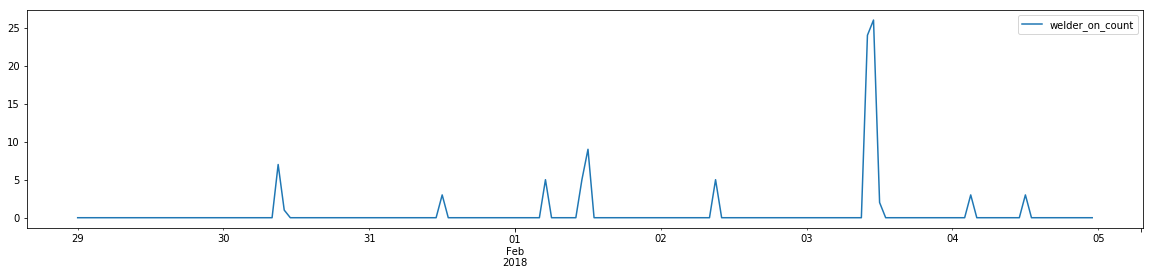

In [92]:
# Show a week's worth of welder usage:
df_week_6 = df_generated_usage_profile.loc[df_generated_usage_profile.index.week == 5]
df_week_6.plot(y='welder_on_count', figsize=(20, 4))

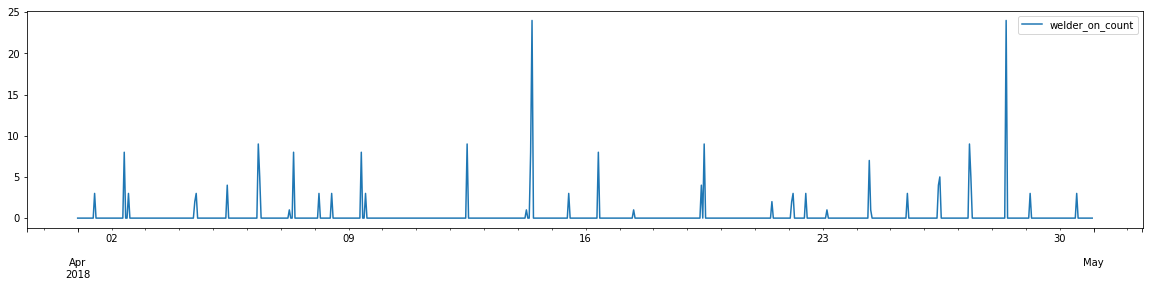

In [93]:
# Show a month's worth of welder usage:
df_february = df_generated_usage_profile.loc[df_generated_usage_profile.index.month == 4]
df_february.plot(y='welder_on_count', figsize=(20, 4))

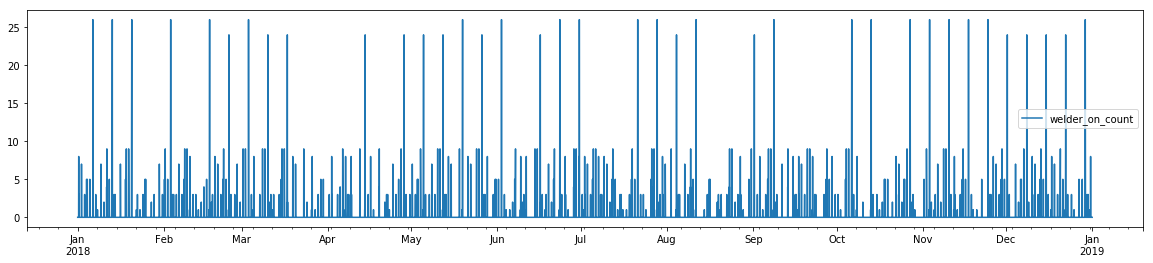

In [94]:
# Show entire year's worth of welder usage:
df_generated_usage_profile.plot(y='welder_on_count', figsize=(20, 4))

In [95]:
# Select a single month (February) to work with using the pivot table:
# pivot_ui(df_generated_usage_profile.loc[df_generated_usage_profile.index.month == 4],
#          cols=['day'],
#          rendererName="Table Barchart",
#          aggregatorName="Average",
#          vals=["welder_on_count"])

## Export yearly usage profile 
The web app doesn't need this data but it can be used for other analysis

In [96]:
df_generated_usage_profile.to_csv(output_profile_name)